In [1]:
import os
import math

import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn

from numpy import load
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from xgboost import XGBClassifier

from sklearn.impute import KNNImputer

from sklearn.svm import SVC

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

rd_seed = 333

## Načtení dat

In [2]:
path_file = os.sep.join(['created_data', 'matrix_semestr_2_personal.csv'])
matrix_bak = pd.read_csv(path_file, sep=",")

## Info o datasetu

In [3]:
matrix_bak.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1738 entries, 0 to 1737
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   studium_id               1738 non-null   int64  
 1   dokoncil_semestr         1738 non-null   float64
 2   BI-PA1_znamka            1738 non-null   float64
 3   BI-PA1_poradi_zapisu     1738 non-null   float64
 4   BI-PA1_semestr           1738 non-null   float64
 5   BI-PAI_znamka            1738 non-null   float64
 6   BI-PAI_poradi_zapisu     1738 non-null   float64
 7   BI-PAI_semestr           1738 non-null   float64
 8   BI-CAO_znamka            1738 non-null   float64
 9   BI-CAO_poradi_zapisu     1738 non-null   float64
 10  BI-CAO_semestr           1738 non-null   float64
 11  BI-PS1_znamka            1738 non-null   float64
 12  BI-PS1_poradi_zapisu     1738 non-null   float64
 13  BI-PS1_semestr           1738 non-null   float64
 14  BI-MLO_znamka           

In [4]:
matrix_bak.mean()

studium_id                 1.420614e+07
dokoncil_semestr           5.863061e-01
BI-PA1_znamka              2.534235e+00
BI-PA1_poradi_zapisu       9.378596e-01
BI-PA1_semestr             9.378596e-01
BI-PAI_znamka              2.144419e+00
BI-PAI_poradi_zapisu       9.113924e-01
BI-PAI_semestr             9.113924e-01
BI-CAO_znamka              1.117664e+00
BI-CAO_poradi_zapisu       8.780207e-01
BI-CAO_semestr             8.780207e-01
BI-PS1_znamka              2.514097e+00
BI-PS1_poradi_zapisu       9.413119e-01
BI-PS1_semestr             9.413119e-01
BI-MLO_znamka              2.180380e+00
BI-MLO_poradi_zapisu       9.021864e-01
BI-MLO_semestr             9.021864e-01
BI-ZMA_znamka              2.563867e+00
BI-ZMA_poradi_zapisu       9.395857e-01
BI-ZMA_semestr             9.395857e-01
pocet_kreditu_semestr_1    2.423936e+01
pohlavi_kod                1.144994e-01
je_cech                    7.773303e-01
datum_zahajeni             2.016903e+03
rok_maturity               2.016186e+03


## Příprava datasetu

### Nastavení indexu

In [5]:
matrix_bak = matrix_bak.set_index(['studium_id'])

### Nastavení target proměnné na nominální

In [6]:
dokoncil_semestr_category = pd.api.types.CategoricalDtype(categories=[0, 1], ordered=False)
matrix_bak['dokoncil_semestr'] = matrix_bak['dokoncil_semestr'].astype(dokoncil_semestr_category)

In [7]:
matrix_bak.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1738 entries, 15613006 to 11740806
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   dokoncil_semestr         1738 non-null   category
 1   BI-PA1_znamka            1738 non-null   float64 
 2   BI-PA1_poradi_zapisu     1738 non-null   float64 
 3   BI-PA1_semestr           1738 non-null   float64 
 4   BI-PAI_znamka            1738 non-null   float64 
 5   BI-PAI_poradi_zapisu     1738 non-null   float64 
 6   BI-PAI_semestr           1738 non-null   float64 
 7   BI-CAO_znamka            1738 non-null   float64 
 8   BI-CAO_poradi_zapisu     1738 non-null   float64 
 9   BI-CAO_semestr           1738 non-null   float64 
 10  BI-PS1_znamka            1738 non-null   float64 
 11  BI-PS1_poradi_zapisu     1738 non-null   float64 
 12  BI-PS1_semestr           1738 non-null   float64 
 13  BI-MLO_znamka            1738 non-null   float64 
 1

### Nastavení atributů na kategorické

In [8]:
# ordinální
attr_category = pd.api.types.CategoricalDtype(categories=[0, 1], ordered=False)
# pohlavi_kod
matrix_bak['pohlavi_kod'] = matrix_bak['pohlavi_kod'].astype(attr_category)
# je_cech
matrix_bak['je_cech'] = matrix_bak['je_cech'].astype(attr_category)
# gymnazium
matrix_bak['gymnazium'] = matrix_bak['gymnazium'].astype(attr_category)
# praha
matrix_bak['praha'] = matrix_bak['praha'].astype(attr_category)
# scio
matrix_bak['scio'] = matrix_bak['scio'].astype(attr_category)
# olym
matrix_bak['olym'] = matrix_bak['olym'].astype(attr_category)
# zkouska
matrix_bak['zkouska'] = matrix_bak['zkouska'].astype(attr_category)
# prominuti
matrix_bak['prominuti'] = matrix_bak['prominuti'].astype(attr_category)

In [9]:
matrix_bak.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1738 entries, 15613006 to 11740806
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   dokoncil_semestr         1738 non-null   category
 1   BI-PA1_znamka            1738 non-null   float64 
 2   BI-PA1_poradi_zapisu     1738 non-null   float64 
 3   BI-PA1_semestr           1738 non-null   float64 
 4   BI-PAI_znamka            1738 non-null   float64 
 5   BI-PAI_poradi_zapisu     1738 non-null   float64 
 6   BI-PAI_semestr           1738 non-null   float64 
 7   BI-CAO_znamka            1738 non-null   float64 
 8   BI-CAO_poradi_zapisu     1738 non-null   float64 
 9   BI-CAO_semestr           1738 non-null   float64 
 10  BI-PS1_znamka            1738 non-null   float64 
 11  BI-PS1_poradi_zapisu     1738 non-null   float64 
 12  BI-PS1_semestr           1738 non-null   float64 
 13  BI-MLO_znamka            1738 non-null   float64 
 1

## Doplnění NaN hodnot

In [10]:
matrix_bak = matrix_bak.fillna(0)

## Modelování

### Bakalář všechny pp

#### Rozdělení datasetu

In [11]:
Xdata = matrix_bak.drop(columns='dokoncil_semestr')
ydata = matrix_bak.dokoncil_semestr

In [12]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.2, random_state=rd_seed, stratify=ydata, shuffle=True) 
print("původní data")
display(Xdata.shape)
display(ydata.shape)
print("trénovací data")
display(Xtrain.shape)
display(ytrain.shape)
print("testovací data")
display(Xtest.shape)
display(ytest.shape)

původní data


(1738, 30)

(1738,)

trénovací data


(1390, 30)

(1390,)

testovací data


(348, 30)

(348,)

#### Funkce pro vybrání vhodných hyperparametrů pomocí křížové validace

In [13]:
def get_best_parameters(param_grid, classifier, xgb=None):
    score = 'f1'
    if xgb:
        model = GridSearchCV(classifier(eval_metric='mlogloss', use_label_encoder=False, tree_method="gpu_hist", enable_categorical=True), param_grid, cv=5, scoring=score)
    else:
        model = GridSearchCV(classifier(), param_grid, cv=5, scoring=score)
    model.fit(Xtrain, ytrain)

    print('Best hyper-parameters are: ')
    print(model.best_params_)
    print()

    means = model.cv_results_["mean_test_score"]
    stds = model.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, model.cv_results_["params"]):
        print("%0.6f (+/-%0.06f) for %r" % (mean, std * 2, params))
    print()
    return model

#### Rozhodovací strom

In [14]:
param_grid = [
    {'criterion':['gini','entropy'],
    'max_depth': range(2,7),
    'min_samples_leaf':[10]}
]

In [15]:
dt_f1 = get_best_parameters(param_grid, DecisionTreeClassifier)

Best hyper-parameters are: 
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 10}

0.852235 (+/-0.022207) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 10}
0.822078 (+/-0.051308) for {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 10}
0.825195 (+/-0.033945) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 10}
0.823058 (+/-0.048213) for {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10}
0.824890 (+/-0.023550) for {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 10}
0.851596 (+/-0.021181) for {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 10}
0.833966 (+/-0.048926) for {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 10}
0.835277 (+/-0.037249) for {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 10}
0.828997 (+/-0.045428) for {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10}
0.827464 (+/-0.025805) for {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 10}



In [16]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, dt_f1.predict(Xtrain))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, dt_f1.predict(Xtest))))

accuracy score (train): 0.823022
accuracy score (test): 0.807471


In [17]:
feature_importances=pd.DataFrame({'features':Xtrain.columns,'feature_importance':dt_f1.best_estimator_.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)

,features,feature_importance
18,pocet_kreditu_semestr_1,0.974192
21,datum_zahajeni,0.025808
0,BI-PA1_znamka,0.000000
1,BI-PA1_poradi_zapisu,0.000000
28,zkouska,0.000000
27,olym,0.000000
26,scio,0.000000
25,praha,0.000000
24,gymnazium,0.000000
23,maturita_nastup_rozdil,0.000000


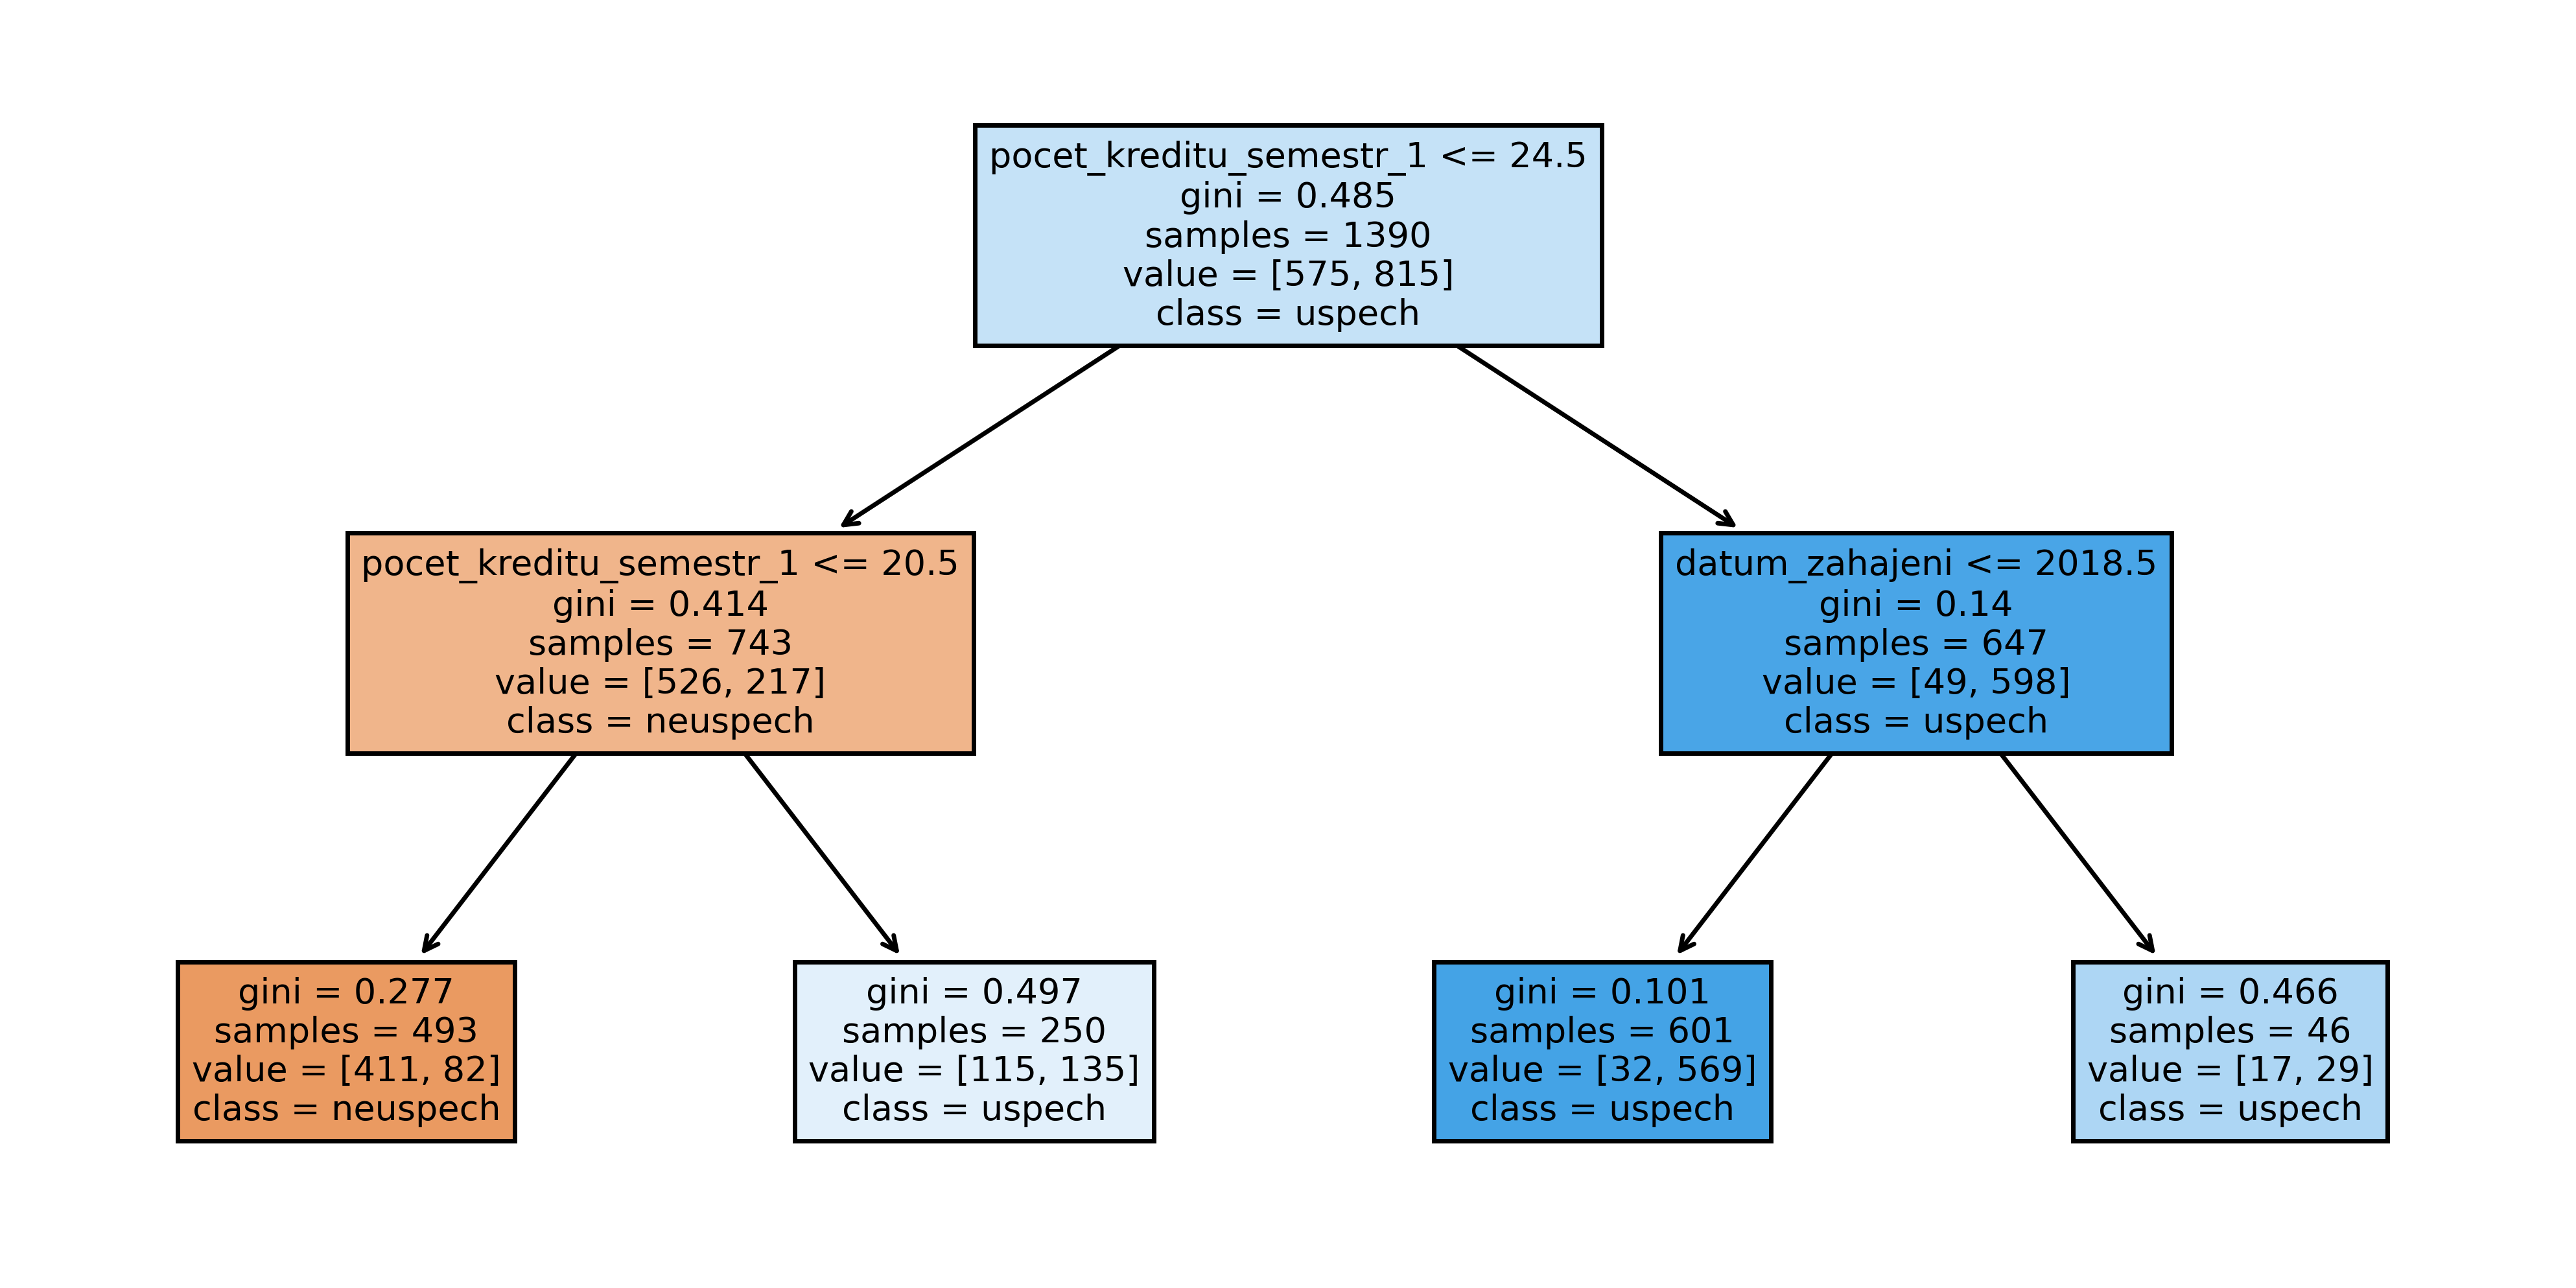

In [18]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,5), dpi=500)
tree.plot_tree(dt_f1.best_estimator_,
               feature_names = Xdata.columns, 
               class_names=['neuspech', 'uspech'],
               filled = True);
fig.savefig('tree_f1_semestr1.png')

#### Random forest

In [19]:
param_grid_rf = {
    'criterion':['gini','entropy'],
    'n_estimators': range(5, 50, 5),
    'max_depth': range(2, 4),
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf':[10]
}

In [20]:
rf_f1 = get_best_parameters(param_grid_rf, RandomForestClassifier)

Best hyper-parameters are: 
{'criterion': 'entropy', 'max_depth': 2, 'max_features': None, 'min_samples_leaf': 10, 'n_estimators': 10}

0.835540 (+/-0.063464) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 5}
0.834159 (+/-0.060228) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 10}
0.837874 (+/-0.044222) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 15}
0.856436 (+/-0.022651) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 20}
0.838025 (+/-0.029947) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 25}
0.839841 (+/-0.043114) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 30}
0.852805 (+/-0.031668) for {'criterion': 'gini', 'max_depth': 2, 'm

In [21]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, rf_f1.predict(Xtrain))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, rf_f1.predict(Xtest))))

accuracy score (train): 0.826619
accuracy score (test): 0.821839


In [22]:
feature_importances=pd.DataFrame({'features':Xtrain.columns,'feature_importance':rf_f1.best_estimator_.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)

,features,feature_importance
18,pocet_kreditu_semestr_1,0.973229
21,datum_zahajeni,0.018173
22,rok_maturity,0.008599
0,BI-PA1_znamka,0.000000
1,BI-PA1_poradi_zapisu,0.000000
28,zkouska,0.000000
27,olym,0.000000
26,scio,0.000000
25,praha,0.000000
24,gymnazium,0.000000


#### Adaboost

In [23]:
param_grid_ab = {
    'n_estimators': range(5, 50, 5),
    'learning_rate': np.arange(0.1, 1., 0.1)
}

In [24]:
ab_f1 = get_best_parameters(param_grid_ab, AdaBoostClassifier)

Best hyper-parameters are: 
{'learning_rate': 0.2, 'n_estimators': 25}

0.852322 (+/-0.035700) for {'learning_rate': 0.1, 'n_estimators': 5}
0.852322 (+/-0.035700) for {'learning_rate': 0.1, 'n_estimators': 10}
0.852322 (+/-0.035700) for {'learning_rate': 0.1, 'n_estimators': 15}
0.852322 (+/-0.035700) for {'learning_rate': 0.1, 'n_estimators': 20}
0.855022 (+/-0.038439) for {'learning_rate': 0.1, 'n_estimators': 25}
0.854375 (+/-0.041269) for {'learning_rate': 0.1, 'n_estimators': 30}
0.855044 (+/-0.042470) for {'learning_rate': 0.1, 'n_estimators': 35}
0.855677 (+/-0.047684) for {'learning_rate': 0.1, 'n_estimators': 40}
0.859622 (+/-0.034454) for {'learning_rate': 0.1, 'n_estimators': 45}
0.852613 (+/-0.036069) for {'learning_rate': 0.2, 'n_estimators': 5}
0.854896 (+/-0.039294) for {'learning_rate': 0.2, 'n_estimators': 10}
0.857222 (+/-0.044241) for {'learning_rate': 0.2, 'n_estimators': 15}
0.856221 (+/-0.044408) for {'learning_rate': 0.2, 'n_estimators': 20}
0.859795 (+/-0.03438

In [25]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, ab_f1.predict(Xtrain))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, ab_f1.predict(Xtest))))

accuracy score (train): 0.833813
accuracy score (test): 0.821839


In [26]:
feature_importances=pd.DataFrame({'features':Xtrain.columns,'feature_importance':ab_f1.best_estimator_.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)

,features,feature_importance
18,pocet_kreditu_semestr_1,0.64
0,BI-PA1_znamka,0.16
21,datum_zahajeni,0.16
22,rok_maturity,0.04
1,BI-PA1_poradi_zapisu,0.00
28,zkouska,0.00
27,olym,0.00
26,scio,0.00
25,praha,0.00
24,gymnazium,0.00


#### Xgboost

In [27]:
param_grid = {
    'eta': np.arange(0.1, 1., 0.1),
    'max_depth': range(3, 8)
}
param_comb = ParameterGrid(param_grid)

In [28]:
xgb_f1 = get_best_parameters(param_grid, XGBClassifier, True)

Best hyper-parameters are: 
{'eta': 0.1, 'max_depth': 3}

0.848084 (+/-0.049035) for {'eta': 0.1, 'max_depth': 3}
0.846394 (+/-0.030598) for {'eta': 0.1, 'max_depth': 4}
0.841724 (+/-0.037456) for {'eta': 0.1, 'max_depth': 5}
0.840134 (+/-0.027628) for {'eta': 0.1, 'max_depth': 6}
0.831066 (+/-0.031150) for {'eta': 0.1, 'max_depth': 7}
0.841486 (+/-0.052055) for {'eta': 0.2, 'max_depth': 3}
0.839602 (+/-0.032432) for {'eta': 0.2, 'max_depth': 4}
0.839267 (+/-0.037934) for {'eta': 0.2, 'max_depth': 5}
0.833551 (+/-0.030836) for {'eta': 0.2, 'max_depth': 6}
0.827658 (+/-0.034043) for {'eta': 0.2, 'max_depth': 7}
0.840376 (+/-0.047277) for {'eta': 0.30000000000000004, 'max_depth': 3}
0.834028 (+/-0.026348) for {'eta': 0.30000000000000004, 'max_depth': 4}
0.834562 (+/-0.031819) for {'eta': 0.30000000000000004, 'max_depth': 5}
0.825185 (+/-0.041116) for {'eta': 0.30000000000000004, 'max_depth': 6}
0.832660 (+/-0.031178) for {'eta': 0.30000000000000004, 'max_depth': 7}
0.839829 (+/-0.038362)

In [29]:
print('accuracy score XGBoost (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, xgb_f1.predict(Xtrain))))
print('accuracy score XGBoost (val): {0:.6f}'.format(metrics.accuracy_score(ytest, xgb_f1.predict(Xtest))))

accuracy score XGBoost (train): 0.870504
accuracy score XGBoost (val): 0.813218


In [30]:
feat_imp = pd.Series(xgb_f1.best_estimator_.get_booster().get_fscore()).sort_values(ascending=False)

In [31]:
feat_imp

pocet_kreditu_semestr_1    130.0
datum_zahajeni              88.0
BI-PA1_znamka               78.0
BI-PS1_znamka               67.0
rok_maturity                54.0
BI-ZMA_znamka               48.0
BI-PAI_znamka               38.0
BI-CAO_znamka               33.0
BI-MLO_znamka               32.0
maturita_nastup_rozdil      17.0
praha                       16.0
BI-CAO_poradi_zapisu        10.0
pohlavi_kod                  9.0
je_cech                      6.0
gymnazium                    5.0
zkouska                      5.0
scio                         2.0
dtype: float64

#### MLP

In [32]:
mlp = MLPClassifier(random_state=1, max_iter=500).fit(Xtrain, ytrain)

In [33]:
print('accuracy score mlp (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, mlp.predict(Xtrain))))
print('accuracy score mlp (val): {0:.6f}'.format(metrics.accuracy_score(ytest, mlp.predict(Xtest))))

accuracy score mlp (train): 0.764748
accuracy score mlp (val): 0.744253


#### Lineární regrese

In [34]:
reg = LinearRegression().fit(Xtrain, ytrain)

In [35]:
print('RMSE reg (test):', np.sqrt(mean_squared_error(reg.predict(Xtrain), np.array(ytrain))))
print('RMSE reg (test):', np.sqrt(mean_squared_error(reg.predict(Xtest), np.array(ytest))))

RMSE reg (test): 0.5828994482567504
RMSE reg (test): 0.575454867465285


#### kNN

In [36]:
param_grid = {
    'n_neighbors' : range(1, 12), # Počet nejbližších sousedů
    'p': range(1, 3), # Stupeň Minkowského vzdálenosti
    'weights': ['uniform', 'distance'], # Aritmetický, nebo vážený průměr
}
param_comb = ParameterGrid(param_grid)

In [37]:
knn = get_best_parameters(param_grid, KNeighborsClassifier)

Best hyper-parameters are: 
{'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}

0.803453 (+/-0.032817) for {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
0.803453 (+/-0.032817) for {'n_neighbors': 1, 'p': 1, 'weights': 'distance'}
0.796993 (+/-0.034498) for {'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
0.796993 (+/-0.034498) for {'n_neighbors': 1, 'p': 2, 'weights': 'distance'}
0.777070 (+/-0.040800) for {'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}
0.791447 (+/-0.030690) for {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
0.779321 (+/-0.037335) for {'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}
0.791144 (+/-0.035456) for {'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
0.824542 (+/-0.016612) for {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
0.821184 (+/-0.025491) for {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
0.826704 (+/-0.018263) for {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
0.826041 (+/-0.020323) for {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
0.8

In [38]:
print('accuracy score knn (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, knn.predict(Xtrain))))
print('accuracy score knn (val): {0:.6f}'.format(metrics.accuracy_score(ytest, knn.predict(Xtest))))

accuracy score knn (train): 0.848921
accuracy score knn (val): 0.807471


## Výsledky

In [39]:
results = pd.DataFrame(columns=['vysledky'], index=['dt', 'rf', 'ab', 'xgb', 'mlp', 'knn'])

### Měřeno accuracy_score

In [40]:
results.loc['dt', 'vysledky'] = round(metrics.accuracy_score(ytest, dt_f1.predict(Xtest)), 3)
results.loc['rf', 'vysledky'] = round(metrics.accuracy_score(ytest, rf_f1.predict(Xtest)), 3)
results.loc['ab', 'vysledky'] = round(metrics.accuracy_score(ytest, ab_f1.predict(Xtest)), 3)
results.loc['xgb', 'vysledky'] = round(metrics.accuracy_score(ytest, xgb_f1.predict(Xtest)), 3)
results.loc['mlp', 'vysledky'] = round(metrics.accuracy_score(ytest, mlp.predict(Xtest)), 3)
results.loc['knn', 'vysledky'] = round(metrics.accuracy_score(ytest, knn.predict(Xtest)), 3)

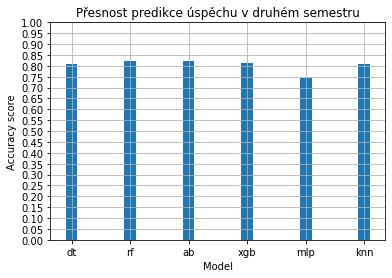

In [41]:
fig, ax = plt.subplots()
width = 0.2
ax.bar(results.index, results['vysledky'].values, width)

ax.set_ylabel('Accuracy score')
ax.set_xlabel('Model')
ax.set_title('Přesnost predikce úspěchu v druhém semestru')

ax.grid(True)
y_values = np.arange(0.0, 1.05, 0.05)
plt.ylim(ymin=0)
plt.ylim(ymax=1)
plt.yticks(y_values)
plt.show()

In [42]:
results

,vysledky
dt,0.807
rf,0.822
ab,0.822
xgb,0.813
mlp,0.744
knn,0.807


### Měřeno f1_score

In [43]:
results_f1 = pd.DataFrame(columns=['vysledky'], index=['dt', 'rf', 'ab', 'xgb', 'mlp', 'knn'])

In [44]:
results_f1.loc['dt', 'vysledky'] = round(metrics.f1_score(ytest, dt_f1.predict(Xtest)), 3)
results_f1.loc['rf', 'vysledky'] = round(metrics.f1_score(ytest, rf_f1.predict(Xtest)), 3)
results_f1.loc['ab', 'vysledky'] = round(metrics.f1_score(ytest, ab_f1.predict(Xtest)), 3)
results_f1.loc['xgb', 'vysledky'] = round(metrics.f1_score(ytest, xgb_f1.predict(Xtest)), 3)
results_f1.loc['mlp', 'vysledky'] = round(metrics.f1_score(ytest, mlp.predict(Xtest)), 3)
results_f1.loc['knn', 'vysledky'] = round(metrics.f1_score(ytest, knn.predict(Xtest)), 3)

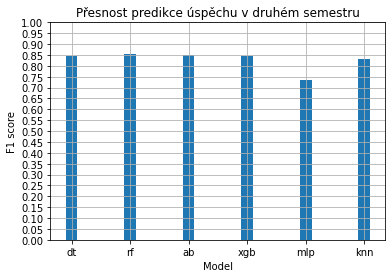

In [45]:
fig, ax = plt.subplots()
width = 0.2
ax.bar(results_f1.index, results_f1['vysledky'].values, width)

ax.set_ylabel('F1 score')
ax.set_xlabel('Model')
ax.set_title('Přesnost predikce úspěchu v druhém semestru')

ax.grid(True)
y_values = np.arange(0.0, 1.05, 0.05)
plt.ylim(ymin=0)
plt.ylim(ymax=1)
plt.yticks(y_values)
plt.show()

In [46]:
results_f1

,vysledky
dt,0.846
rf,0.856
ab,0.852
xgb,0.843
mlp,0.733
knn,0.831
